**Class 1: Markov Decision Processes**

Notation: MDP = Markov Decision Process
1. [Everything you need to know](#everything)
2. [A gentle introduction](#intro)
    1. [A medical prescription example](#example)
    2. [Patient variables](#vars)
    3. [Prescription](#prescription)
    4. [Patient evolution](#evolution)
    5. [Physician's goal](#goal)
    6. [Wrap-up](#wrapup)
3. [Modeling sequential decision problems with MDPs](#modeling)
    1. [Definition](#mdp)
    1. [My first Markov Decision Processes](#frozenlake)
    2. [Some Gym notions](#gym)
    3. [Policies](#policies)
    4. [Value Functions](#values)
    5. [Optimal policies](#optimal)
    6. [Evaluation equation](#eval)
    7. [Optimality equation](#optimality)
    8. [Summary](#summary)
4. [Before you leave](#before)
    1. [Limitations](#limits)
    2. [A common misconception](#misconception)

The previous class (RL0) provided the key intuitions about RL. RL is about **learning** to **control** dynamic systems. This class will present the family of systems that we build the RL theory upon. They are called Markov Decision Processes.

# <a id="everything"></a>Everything you need to know


Everything you should remember after this session.
<div class="alert alert-success">
<ul>
<li> A Markov Decision Process (MDP) is a 4-tuple $\langle S,A,p,r \rangle$. $S$ is the state space, $A$ is the action space, $p(s'|s,a)$ the transition model and $r(s,a)$ the reward model.
<li> A policy is a mapping $\pi:S\rightarrow A$ that specifies what to do in a given state.
<li> Value function of a policy: $V^\pi(s)=\mathbb{E}\left( \lim\limits_{H\rightarrow\infty} \sum\limits_{t = 0}^H \gamma^t r_t \bigg| s_0 = s, \pi \right)$
<li> State-action value function of a policy $Q^\pi(s,a) = \mathbb{E}\left( \lim\limits_{H\rightarrow\infty} \sum\limits_{t = 0}^H \gamma^t r_t \bigg| s_0 = s, a_0=a, \pi \right)$
<li> Optimal policy $\pi^*$ dominates every other possible policy in every state: $\forall s, \ V^*(s) = V^{\pi^*}(s) \geq V^\pi(s)$
<li> Evaluation equation: $V^\pi \in \mathcal{F}\left(S,\mathbb{R}\right)$ is the only solution to $V\left(s\right) = (T^\pi V)(s) = r\left(s,\pi\left(s\right)\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,\pi\left(s\right)\right) V\left(s'\right)$<br>
Similarly, $Q^\pi \in \mathcal{F}\left(S\times A,\mathbb{R}\right)$ is the only solution to $Q\left(s,a\right) = (T^\pi Q)(s,a) = r\left(s,a\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,a\right) Q\left(s', \pi\left(s'\right)\right)$
<li> Properties of $T^\pi$ 1) $V=T^\pi V$ is a linear system, 2) $T^\pi$ is a contraction mapping over $\mathcal{F}(S,\mathbb{R})$ or $\mathcal{F}(S\times A,\mathbb{R})$.
<li> Finding $V^\pi$ or $Q^\pi$: by matrix inversion or by repeatedly applying $T^\pi$ to any initial function.
<li> Optimality equation: $V^* \in \mathcal{F}\left(S,\mathbb{R}\right)$ is the only solution to $V(s) = (T^* V) (s) = \max\limits_{a\in A} \left\{ r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a) V(s') \right\}$<br>
Similarly, $Q^* \in \mathcal{F}\left(S\times A,\mathbb{R}\right)$ is the only solution to $Q(s,a) = (T^* Q) (s,a) = r(s,a) + \gamma \sum\limits_{s'\in S}p(s'|s,a) \max\limits_{a'\in A} Q(s',a')$
<li> $T^*$ is a contraction mapping.
<li> An OpenAI Gym environment has a standard API with 5 methods (step, reset, render, close, seed) and 3 attributes (action_space, observation_space, reward_range). Environment-specific features can be accessed via the "unwrapped" attribute.
</ul>
</div>

Of course, all this seems very obscure right now and the block above will only serve as a reminder when you re-open the notebook later. We will introduce every concept intuitively and progessively.

# <a id="intro"></a>A gentle introduction

## <a id="example"></a>A medical prescription example

<img src="img/patient-doctor.png" style="height: 200px;">

A patient walks into a clinic with her medical file (medical history, x-rays, blood work, etc.). You, as her doctor, need to write a prescription. Let us use this example to formalize the process of deciding what to write on the prescription.

<div class="alert alert-warning">

**Exercice:** take a minute to formalize the problem of writing a prescription.
</div>

This exercice is open-ended: there is no single right answer. But before we move any further it is good to try to be a bit creative. Feel free to name variables, decisions, history of the patient to write the problem of writing this prescription. The goal here is to do it your way, not the RL way. If they match, it's all the better, but it's not necessary, so feel free to be creative.

## <a id="vars"></a>Patient variables

<img src="img/patient_file.png" style="height: 100px;"> </img> <br>

<center>
Patient state now: $S_0$  <br>
Future states: $S_t$
</center>

The medical file of the patient allows us to define a number of variables that characterize the patient now. We will write $S_0$ the vector of these variables. Future measurements will be noted $S_t$.

$S_t$ is a random vector, taking different values in a *patient description space* $S$ at different time steps.

<div class="alert alert-warning">

**Question:** what kind of variables are there in $S_t$? Scalars? Booleans? Images? Time series?
</div>

## <a id="prescription"></a>Prescription

<img src="img/prescription.png" style="height: 100px;"> </img> <br>

<center>
Prescription: $\left( A_t \right)_{t\in\mathbb{N}} = (A_0, A_1, A_2, ...)$
</center>

The prescription is a series of recommendation we give to the patient over the course of treatment. It is thus a sequence $\left( A_t \right)_{t\in\mathbb{N}} = (A_0, A_1, A_2, ...)$ of variables $A_t$.

These treatments $A_t$ are random variables too, taking their value in some space $A$.

<div class="alert alert-warning">

**Question:** what kind of variables are there in $A_t$?
</div>

## <a id="evolution"></a>Patient evolution

<img src="img/patient_evolution.png" style="height: 100px;"> </img> <br>

<center>
    $\mathbb{P}(S_t)$?
</center>

The patient evolves over time steps. Her evolution follows a certain probability distribution $\mathbb{P}(S_t)$ over descriptive states.

So $\left( S_t \right)_{t\in\mathbb{N}}$ defines a *random process* that describes the patient's evolution under the influence of past $S_t$ and $A_t$.

## <a id="goal"></a>Physician's goal

<img src="img/patient_happy.png" style="height: 100px;"> </img> <br>

$$J \left( \left(S_t\right)_{t\in \mathbb{N}}, \left( A_t \right)_{t\in \mathbb{N}} \right)?$$

The physician's goal is to bring the patient from an unhealthy state $S_0$ to a healthy situation. This goal is not only defined by a final state of the patient but by the full trajectory followed by the variables $S_t$ and $A_t$. For example, prescribing a drug that damages the patient's liver, or letting the patient experience too much pain over the course of treatment is discouraged.

We define a criterion $J \left( \left(S_t\right)_{t\in \mathbb{N}}, \left( A_t \right)_{t\in \mathbb{N}} \right)$ that allows to quantify how good a trajectory in the joint $S\times A$ space is.

<div class="alert alert-warning">

**Question:** how would you write this function explicitly?
</div>

## <a id="wrapup"></a>Wrap-up

- Patient state $S_t$  (random variable)
- Physician instruction $A_t$ (random variable)
- Prescription $\left( A_t \right)_{t\in\mathbb{N}}$   
- Patient's evolution $\mathbb{P}(S_t)$  
- Patient's trajectory $\left( S_t \right)_{t\in\mathbb{N}}$ random process
- Value of a trajectory $J \left( \left(S_t\right)_{t\in \mathbb{N}}, \left( A_t \right)_{t\in \mathbb{N}} \right)$  

It seems reasonable that the physician's recommendation $\mathbb{P}(A_t)$ at step $t$ be dependent on previously observed states $\left(S_0, \ldots, S_t\right)$ and recommended treatments $\left(A_0, \ldots, A_{t-1}\right)$.

# <a id="modeling"></a>Modeling sequential decision problems with Markov Decision Processes

## <a id="mdp"></a>Definition

Let's take a higher view and develop a general theory for describing problems such as writing a prescription for our patient. We wish to control the trajectory of a system that we model as a Markov Decision Process.

<img src="img/dynamic.png" style="height: 240px;"></img>

<div class="alert alert-success"><b>Markov Decision Process (MDP)</b><br>
A Markov Decision Process is given by:
<ul>
<li> A set of states $S$
<li> A set of actions $A$
<li> A (Markovian) transition model $\mathbb{P}\left(S_{t+1} | S_t, A_t \right)$, noted $p(s'|s,a)$
<li> A reward model $\mathbb{P}\left( R_t | S_t, A_t, S_{t+1} \right)$, noted $r(s,a)$ or $r(s,a,s')$
<li> A set of discrete decision epochs $T=\{0,1,\ldots,H\}$
</ul>
</div>

<a href="#moreMDP" data-toggle="collapse"> More?</a><br>
<div id="moreMDP" class="collapse">
<ol>
<li> Illustration of an MDP's components:
<img src="img/transitions.png">
<li> And the resulting dynamics:
<img src="img/mdp2.png">
<li> If $H\rightarrow\infty$ we have an infinite horizon planning problem.<br>
<li> It is not obvious that the formulations $\mathbb{P}\left( R_t | S_t, A_t, S_{t+1} \right)$, $r(s,a)$ and $r(s,a,s')$ are actually equivalent. We will admit that for now and will only use $r(s,a)$.
<li> $S$ and $A$ may each be either:
    <ul>
    <li> arbitrary finite sets,
    <li> arbitrary countable infinite sets,
    <li> compact subsets of finite dimensional Euclidean space, or
    <li> non-empty Borel subsets of complete, separable metric spaces.
    </ul>
<li> Markov transition model: $p(s_{t+1}|s_t,a_t,s_{t-1},a_{t-1},\ldots) = p(s_{t+1}|s_t,a_t)$
</ol>
</div>
Since we will only work with infinite horizon problems, we shall identify the MDP with the 4-tuple $\langle S,A,p,r\rangle$.<br>

<div class="alert alert-warning"><b>Question:</b><br>What hypothesis has been introduced by comparison to the patient model in the introductory example?</div>

<div class="alert alert-danger"><a href="#answers0" data-toggle="collapse"><b>Answer:</b></a><br>
<div id="answers0" class="collapse">
The probability $\mathbb{P}(S_{t+1})$ is only conditioned by $S_t$ and $A_t$. It does not depend on the state and action history before $t$. In other words the dynamics of the model only depend on the current state and action: the transition model respects Markov's property.
    
If there were no actions, the random process of $S_t$ would be a *Markov process* (or Markov chain). Since transitions are controllable via the random variable $A_t$, this is called a Markov *decision* process.
    
Alternate name: Controlled Markov Chain.
</div>
</div>

## <a id="frozenlake"></a>My first Markov Decision Process

Curing patients is a conceptually difficult task. We shall start with the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) game and work our way to more general concepts. It's also the occasion to familiarize with OpenAI Gym.

In [12]:
import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

In [13]:
env = gym.make('FrozenLake-v0')
_=env.render()


SFFF
FHFH
FFFH
HFFG


Let's take a look at this problem's description (using for example `help(fl.FrozenLakeEnv)`). We read:

`|  Winter is here. You and your friends were tossing around a frisbee at the park
|  when you made a wild throw that left the frisbee out in the middle of the lake.
|  The water is mostly frozen, but there are a few holes where the ice has melted.
|  If you step into one of those holes, you'll fall into the freezing water.
|  At this time, there's an international frisbee shortage, so it's absolutely imperative that
|  you navigate across the lake and retrieve the disc.
|  However, the ice is slippery, so you won't always move in the direction you intend.
|  The surface is described using a grid like the following
|  
|      SFFF
|      FHFH
|      FFFH
|      HFFG
|  
|  S : starting point, safe
|  F : frozen surface, safe
|  H : hole, fall to your doom
|  G : goal, where the frisbee is located
|  
|  The episode ends when you reach the goal or fall in a hole.
|  You receive a reward of 1 if you reach the goal, and zero otherwise.`

So it's a game of navigation.

<div class="alert alert-warning"><b>Questions:</b><br>What are the possible states of an agent in this game?<br> What are its possible actions?<br>How would you describe the result of action $a$ in state $s$?<br> How would you formalize mathematically the goal of an agent?</div>

<div class="alert alert-danger"><a href="#answers1" data-toggle="collapse"><b>Answers:</b></a><br>
<div id="answers1" class="collapse">
States set: the 16 positions on the map.<br>
Actions set: the 4 actions $\{$N,S,E,W$\}$<br>
$s'$ resulting from $(s,a)$ follows a distribution $P(s'|s,a)$<br>
Since each time step yields a reward, reaching the goal $\Leftrightarrow$ $\max \sum r_t$
</div>
</div>

Let's confirm that:

In [7]:
print(env.observation_space)
print(env.action_space)

Discrete(16)
Discrete(4)


Using `print(help(gym.envs.toy_text.discrete))` one sees that all discrete state environments (such as FrozenLake) have the same inner attributes:

`|  - nS: number of states
|  - nA: number of actions
|  - P: transitions (*)
|  - isd: initial state distribution (**)
|  
|  (*) dictionary dict of dicts of lists, where
|    P[s][a] == [(probability, nextstate, reward, done), ...]
|  (**) list or array of length nS`

In [8]:
print(env.unwrapped.P[1][0])
print(env.unwrapped.P[1][0][0])

[(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True)]
(0.3333333333333333, 1, 0.0, False)


Just a few utilities for the FrozenLake environment (so that you don't spend time on useless things):

In [9]:
actions = {fl.LEFT: '\u2190', fl.DOWN: '\u2193', fl.RIGHT: '\u2192', fl.UP: '\u2191'}
print(actions)

def to_s(row,col):
    return row*env.unwrapped.ncol+col

def to_row_col(s):
    col = s%env.unwrapped.ncol
    row = int((s-col)/env.unwrapped.ncol)
    return row,col

{0: '←', 1: '↓', 2: '→', 3: '↑'}


## <a id="gym"></a>Some Gym notions

Gym environments all are encapsulated so that they have the same API. This can be described by calling `help(gym.Env)` Namely, they all have 5 methods and 3 attributes.

Methods:
- `step` --- Runs one timestep of the environment's dynamics. When end of episode is reached, you are responsible for calling `reset()`  to reset this environment's state. Accepts an action and returns a tuple (observation, reward, done, info).
- `reset` --- Resets the state of the environment and returns an initial observation.
- `render` --- Renders the environment. The set of supported modes varies per environment. See `help(gym.Env.render)` for details and arguments.
- `close` --- Cleans everything up, shuts the light and closes the door.
- `seed` --- Sets the seed for this env's random number generator(s).

Attributes:
- `action_space` --- The Space(*) object corresponding to valid actions.
- `observation_space` --- The Space(*) object corresponding to valid observations.
- `reward_range` --- A tuple corresponding to the min and max possible rewards.

(*) `Space` is a class (`help(gym.Space)`) that defines a set, be it continuous or discrete, with some useful methods. It is used specifically as the type of the action and observation spaces.

Beyond those common API methods, some class-specific methods or attributes can be accessed by using the `unwrapped` attribute of each environment (if present) as in the example above.

General references on OpenAI Gym:
- [The short description paper](https://arxiv.org/pdf/1606.01540.pdf)
- [The github page](https://github.com/openai/gym/blob/master/gym/envs/toy_text/discrete.py) (the most useful resource!)
- [The general introduction to Gym](https://gym.openai.com/docs/)
- [The deprecated list of environments](https://gym.openai.com/envs/) (refer to the github page for the latest version).

## <a id="policies"></a>Policies

Now the question is: "formally, how does one write the behaviour of an agent in the game?".

Using the notations introduced earlier, we want to decide on the distribution $\mathbb{P}\left(A_t\right)$ at each time step.

At time step $t$, action $a$ is picked with probability $\delta_t(a|h)$, where $h$ is the history of state and actions seen between the initial time step and $t$.

The collection of all $\delta_t$ distributions defines a behaviour. Such a behaviour provides the agent with an action at each time step, given everything the agent has seen since the game started. We shall call such a behaviour a *policy*.

<div class="alert alert-success"><b>Policy $\pi$</b><br>
A policy $\pi$ is a sequence of decision rules $\delta_t$: $\pi = \{\delta_t\}_{t\in T}$,<br>
with $\delta_t : \left\{\begin{array}{ccc}
S^{t+1}\times A^{t} & \rightarrow & \mathcal{D}'(A)\\h & \mapsto & \delta_t(a|h)
\end{array}\right.$
</div>
In other words:
$\delta_t(a|h)$ indicates<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; the distribution over action $a$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; to undertake at time $t$, given<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; the history of states/actions $h$.

This is a *history-dependent, non-stationary, stochastic* policy.

Ok, that's quite a convoluted definition but we said we wanted to be generic so we will keep that for now.

<div class="alert alert-warning"><b>Exercice</b><br>
In the patient example, suppose the physician tells the patient to take drug A every day for 5 days, then drug B every two days for 9 days, then come back for a check-up. The physician adds to take drug C once a day if the patient feels pain over two consecutive days. Can you write the sequence of corresponding decision rules?
</div>

<div class="alert alert-danger"><a href="#answers2" data-toggle="collapse"><b>Answer:</b></a><br>
<div id="answers2" class="collapse">
This prescription is made over a finite horizon $H=14$ days.  
    
The prescription is deterministic: the distribution over actions is a Dirac. We will write it $a_t = \delta_t(h)$.
    
The prescription depends on the two last states of the patient. Precisely, it depends on the boolean state variable "is there pain?". So we can write $\delta_t(h) = \delta_t(s_t,s_{t-1})$.  

Consequently, the policy is:  
For $t \in [1, 5]$, $\delta_t(s_t,s_{t-1}) = (A,C)$ if $pain(s_t,s_{t-1})=True$ and (A) otherwise.  
For $t \in [6, 14]$, $\delta_t(s_t,s_{t-1}) = (B,C)$ if $pain(s_t,s_{t-1})=True$ and (B) otherwise.  
</div>
</div>

## <a id="values"></a>Value functions

Now we want to find the best strategy for our game, ie. the best policy, so the question is "how can one say that one policy is better than another?". Consequently, we need to define criteria over policies.

The baseline idea is to say that the criterion should reflect what the agent gains by applying the policy. Two problems arise:
- this gain depends on the initial state
- two applications of the policy can result in two different trajectories since the agent's environment is stochastic (it's an MDP, remember)

Let us introduce three criteria as examples to give a general intuition of various possibilities. Bear in mind that many more (exotic) criteria are possible, they simply express what we consider an optimal behaviour. The three criteria below are actually functions, that map an **initial state** $s$ to the **expected** return the agent gets by applying the policy from $s$.

<table>
<tr>
    <td> Average reward </td>
    <td width="300px">$V(s) = \mathbb{E}\left( \lim\limits_{H\rightarrow\infty}  \frac{1}{H} \sum\limits_{t = 0}^H r_t \bigg| s_0 = s \right)$ </td>
    <td></td>
</tr>
<tr>
    <td> Total reward </td>
    <td>$V(s) = \mathbb{E}\left( \lim\limits_{H\rightarrow\infty} \sum\limits_{t = 0}^H r_t \bigg| s_0 = s \right)$ </td>
    <td></td>
</tr>
<tr>
    <td>Discounted reward </td>
    <td>$V(s) = \mathbb{E}\left( \lim\limits_{H\rightarrow\infty} \sum\limits_{t = 0}^H \gamma^t r_t \bigg| s_0 = s \right)$ </td>
    <td width="150px">with $0\leq \gamma<1$</td>
</tr>
</table>

- The average reward criterion characterizes the average reward per time step the agent gets. This can be useful in some control applications. However, in the case of FrozenLake, we don't want to average our rewards, we want to get our frisbee as soon as possible.
- The total reward criterion seems more adapted: it maximizes the cumulated rewards obtained during an episode. But it does not discriminate whether they were obtained at the beginning or late in the episode. Additionally, it suffers from a major flaw: for infinite horizon problems, even if the reward model is bounded, this sum might diverge. So we need a better formulation for the general case of infinite horizon problems.
- The discounted reward criterion suits our needs. The gamma factor ($0\leq \gamma<1$) guarantees that with bounded reward models $r$, the sum always converges. Also it has the properties we desire: a reward of 1 obtained at the first time step weights 1 in the final criterion, while a reward of 1 obtained after $t$ time steps only weights $\gamma^t$; it is *discounted* by $\gamma^t$ (hence the criterion's name).

From now on we shall concentrate on the discounted reward criterion. Given this criterion, we can introduce the notion of a value function.<br>

<div class="alert alert-success"><b>Value function $V^\pi$ of a policy $\pi$ under a $\gamma$-discounted criterion</b><br>
$$V^\pi : \left\{\begin{array}{ccl}
S & \rightarrow & \mathbb{R}\\
s & \mapsto & V^\pi(s)=\mathbb{E}\left( \lim\limits_{H\rightarrow\infty} \sum\limits_{t = 0}^H \gamma^t r_t \bigg| s_0 = s, \pi \right)\end{array}\right. $$
</div>

<div class="alert alert-warning"><b>Exercice</b><br>
Use the FrozenLake environment we've introduced earlier to obtain a Monte-Carlo estimate of $V^\pi(s_0)$ over 100000 trials, with $s_0$ being the initial state and $\pi$ being a simple policy that always goes right. Take $\gamma = 0.9$.
</div>
Note that $\gamma^{200} \sim 10^{-9}$ so any reward obtained after 200 time steps will have a negligible contribution to $V^\pi(s_0)$, thus rolling an episode out for 200 time steps should be sufficient.

In [17]:
# %load solutions/RL1_exercice1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


value estimate: 0.01309986502660596
value variance: 0.07565863789975193


## <a id="optimal"></a>Optimal policies

The fog clears up a bit: we can now compare policies given an initial state. We can now define what an optimal policy is.<br>
<br>
<div class="alert alert-success"><b>Optimal policy $\pi^*$</b><br>
$\pi^*$ is said to be optimal iff $\pi^* \in \arg\max\limits_{\pi} V^\pi$.<br>
<br>
    
A policy is optimal if it **dominates** over any other policy in every state:
$$\pi^* \textrm{ is optimal}\Leftrightarrow \forall s\in S, \ \forall \pi, \ V^{\pi^*}(s) \geq V^\pi(s)$$
</div>

We now get to our first fundamental result. Fortunately for us...<br>
<br>
<div class="alert alert-success"><b>Optimal policy theorem</b><br>
For $\left\{\begin{array}{l}
\gamma\textrm{-discounted criterion}\\
\textrm{infinite horizon}
\end{array}\right.$, 
there always exists at least one optimal stationary, deterministic, Markovian policy.
</div>

Let's explain a little:
- Markovian : $\left\{\begin{array}{l}
\forall \left(s_i,a_i\right)\in \left(S\times A\right)^{t-1}\\
\forall \left(s'_i,a'_i\right)\in \left(S\times A\right)^{t-1}
\end{array}\right., \delta_t\left(a|s_0, a_0, \ldots, s_t\right) = \delta_t\left(a|s'_0, a'_0, \ldots, s_t\right)$.  
One writes $\delta_t(a|s)$.
- Stationary : $\forall (t,t')\in \mathbb{N}^2, \delta_t = \delta_t'$.  
One writes $\pi = \delta_0$.
- Deterministic : $\delta_t(a|h) = \left\{\begin{array}{l}
1\textrm{ for a single }a\\
0\textrm{ otherwise}
\end{array}\right.$.

So in simpler words, we know that among all possible optimal policies, at least one is a function $\pi:S\rightarrow A$.

That helps a lot: we don't have to search for optimal policies in that complex family of history-dependent, stochastic, non-stationary policies, can simply search for a function $\pi(s)=a$ that maps states to actions.

<a href="#optPol" data-toggle="collapse"> Curious to know why?</a><br>
<div id="optPol" class="collapse">
    The proof (very simple but a little long) is in chapter 6 of <b>Markov Decision Processes</b> (book by Martin L. Puterman).<br>
To give you the general flavour:
<ul>
<li> The infinite horizon leads to the existence of an optimal <b>stationary</b> policy: if the horizon is infinitely far, the optimal decision rule $n$ steps before the end if the same as the one $n+1$ steps before the end (watch out, this intuition can be very false in other contexts).
<li> The <b>Markovian</b> property of $p(s'|s,a)$ allows to get optimal Markovian policies.
<li> The <b>deterministic</b> part is somehow more tricky but just note that this result only holds for single-player MDPs. For a two-agents competitive game for example (like poker for instance), there is no deterministic optimal policy.
</ul>
</div>

## <a id="eval"></a>Evaluation equation

Let's play a little bit (mathematically) with our new toys.<br>

<div class="alert alert-warning"><b>Question</b><br>
What's the value of "$a$ for the first step, then $\pi$, starting from $s$"?
</div>

Note: the answer uses the discounted criterion's definition and the value function of $\pi$.<br>

<div class="alert alert-danger"><a href="#answersQsa" data-toggle="collapse"><b>Answer:</b></a><br>
<div id="answersQsa" class="collapse">
\begin{align*}
Q^\pi(s,a) & = \mathbb{E}\left( \sum\limits_{t=0}^\infty \gamma^t r\left(s_t, a_t\right) \bigg| s_0 = s, a_0=a, \pi \right)\\
 & = r\left(s,a\right) + \mathbb{E}\left( \sum\limits_{t=1}^\infty \gamma^t r\left(s_t, a_t\right) \bigg| s_0 = s, a_0=a, \pi \right)\\
 & = r\left(s,a\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,a\right) \mathbb{E}\left( \sum\limits_{t=1}^\infty \gamma^{t-1} r\left(s_t, a_t\right) \bigg| s_1 = s', \pi \right)\\
 & = r\left(s,a\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,a\right) V^\pi\left(s'\right)
\end{align*}
</div>
</div>

Note that we have introduced the very important state-action value function $Q^\pi$.
<div class="alert alert-success"><b>State-action value function</b><br>
$$Q^\pi(s,a) = \mathbb{E}\left( \sum\limits_{t=0}^\infty \gamma^t r\left(s_t, a_t\right) \bigg| s_0 = s, a_0=a, \pi \right)$$
</div>

<div class="alert alert-warning"><b>Exercice</b><br>
Write a function that computes $Q^\pi$ given $V^\pi$ for FrozenLake.
</div>

In [ ]:
# %load solutions/RL1_exercice2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


That's interesting: given a policy $\pi$, the best one-step lookahead action can be selected by maximizing $Q^\pi$. To improve on a policy $\pi$, it is more useful to know $Q^\pi$ than $V^\pi$ and pick the *greedy* action.

<div class="alert alert-warning"><b>Exercice</b><br>
Write a function that takes a $Q$ function for FrozenLake and returns the greedy policy.
</div>

In [ ]:
# %load solutions/RL1_exercice3.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


Let's remark that $V^\pi(s) = Q^\pi(s,\pi(s))$. Let's replace that above and we get an important equation to characterize $V^\pi$.

<div class="alert alert-success"><b>Evaluation equation</b><br>
$V^\pi$ is a solution to the linear system:
\begin{gather*}
V^\pi\left(s\right) = r\left(s,\pi\left(s\right)\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,\pi\left(s\right)\right) V^\pi\left(s'\right)\\
V^\pi = r^\pi + \gamma P^\pi V^\pi = T^\pi V^\pi
\end{gather*}
Similarly:
\begin{gather*}
Q^\pi\left(s,a\right) = r\left(s,a\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,a\right) Q^\pi\left(s', \pi\left(s'\right)\right)\\
Q^\pi = r + \gamma P Q^\pi = T^\pi Q^\pi
\end{gather*}
</div>

<a href="#morePpi" data-toggle="collapse"> What are $P^\pi$, $r^\pi$ and $T^\pi$ here?</a><br>
<div id="morePpi" class="collapse">
When the state space is discrete, $V^\pi$ is vector of size $|S|$, $P^\pi$ is a matrix containing the values $P^\pi_{ij} = p\left(s_j|s_i,\pi(s_i)\right)$ and, similarly, $r^\pi$ is a vector containing the values $r^\pi_i = r(s_i,\pi(s_i))$. In better words, $P^\pi$ is the <i>transition kernel</i> of the Markov chain describing the state dynamics under policy $\pi$ and $r^\pi$ is the associated reward model.<br>
<br>
This generalizes straightforwardly to the continuous states case: $V^\pi$ is a function in the $\mathcal{F}(S,\mathbb{R})$ function space (the generalization of the vector in the previous sentence), $r^\pi$ becomes the function $s\mapsto r(s,\pi(s))$ and  $P^\pi$ becomes the operator over $\mathcal{F}(S,\mathbb{R})$ that maps function $V$ to function $s\mapsto \int\limits_{s'\in S} p\left(s'|s,\pi\left(s\right)\right) V\left(s'\right)ds'$.<br>
<br>
In the same fashion, one can define the $T^\pi$ operator. In the discrete state space case, $T^\pi$ is the linear operator in $\mathbb{R}^{|S|}$ that maps $V^\pi$ to $r^\pi + \gamma P^\pi V^\pi$.<br>
<br>
In the continuous state space case, $T^\pi$ is the linear operator in $\mathcal{F}(S,\mathbb{R})$ that maps $V^\pi$ to the function $s\mapsto r\left(s,\pi\left(s\right)\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,\pi\left(s\right)\right) V^\pi\left(s'\right)$.
</div>

<a href="#moreEval" data-toggle="collapse"> A remark</a><br>
<div id="moreEval" class="collapse">
For stochastic policies:
$\forall s\in S, \quad V^\pi(s) = \sum\limits_{a\in A} \pi(a|s) \left(r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a)V^\pi(s') \right)$
</div>

We've gone far from our original FrozenLake problem. Let's make all this very concrete:
- A policy $\pi$ is an agent's behaviour
- In every state $s$, one can expect to gain $V^\pi(s)$ in the long run by applying $\pi$
- The function $V^\pi$ actually obeys the linear system of equations above that simply link the value of a state with the values of its successors in an episode.

We can stop for a minute on the $T^\pi$ evaluation operator (that maps a function $S\rightarrow\mathbb{R}$ to a function $S\rightarrow\mathbb{R}$) and the search for $V^\pi$.

<div class="alert alert-success"><b>Properties of $T^\pi$</b><br>
<ol>
<li> $T^\pi$ is linear.<br>
$\Rightarrow$ Solving $V^\pi = T^\pi V^\pi$ and $Q^\pi = T^\pi Q^\pi$ by matrix inversion?<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;With $\gamma<1$, $V^\pi = \left(I-\gamma P^\pi\right)^{-1}r^\pi$ and $Q^\pi = \left(I-\gamma P\right)^{-1}r^\pi$
<li> With $\gamma<1$, $T^\pi$ is a $\| \cdot \|_\infty$-contraction mapping over the $\mathcal{F}(S,\mathbb{R})$ (resp. $\mathcal{F}(S\times A,\mathbb{R})$) Banach space.<br>
$\Rightarrow$ With $\gamma<1$, $V^\pi$ (resp. $Q^\pi$) is the unique solution to the (linear) fixed point equation:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$V=T^\pi V$ (resp. $Q=T^\pi Q$).
</ol>
</div>

<div class="alert alert-warning"><b>Exercice</b><br>
Use the first property above to compute $V^\pi$ for the policy that always moves right. To do this, you'll need to compute $r^\pi$ and $P^\pi$. Again, $\gamma = 0.9$.
Check if your result for $V^\pi(s_0)$ is consistent with the Monte Carlo estimate.
</div>

In [21]:
# %load solutions/RL1_exercice4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


[ 1.308e-02  1.176e-02  2.744e-02  1.576e-16  1.875e-02  1.234e-16
  6.402e-02  2.101e-16  4.944e-02  1.460e-01  1.860e-01 -1.179e-16
  0.000e+00  3.008e-01  5.559e-01  0.000e+00]


<div class="alert alert-warning"><b>Exercice</b><br>
Generalize the code above to a function that takes a policy as input. We'll suppose in this case that the policy is an array of actions.
</div>

In [25]:
# %load solutions/RL1_exercice5.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


In [24]:
pi0 = fl.RIGHT*np.ones((env.observation_space.n))

V_pi0 = policy_eval_lin(pi0)
print(V_pi0)

[ 1.308e-02  1.176e-02  2.744e-02  1.576e-16  1.875e-02  1.234e-16
  6.402e-02  2.101e-16  4.944e-02  1.460e-01  1.860e-01 -1.179e-16
  0.000e+00  3.008e-01  5.559e-01  0.000e+00]


<div class="alert alert-warning"><b>Exercice</b><br>
Use the second property above to compute $V^\pi$ for the policy that always moves right. To do this, you'll need to remember that since $T^\pi$ is a contraction mapping, the sequence $V_{n+1}=T^\pi V_n$ converges to $T^\pi$'s fixed point (which happens to be $V^\pi$ according to the property). Again, $\gamma = 0.9$. For a start, apply $T^\pi$ for a fixed number of steps `max_iter`.
Check if your result is consistent with the previous estimate.
</div>

In [27]:
# %load solutions/RL1_exercice6.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


[0.013 0.012 0.027 0.    0.019 0.    0.064 0.    0.049 0.146 0.186 0.
 0.    0.301 0.556 0.   ]


Between two iterations in the algorithm above, the distance between $V_{n+1}$ and $V_n$ decreases as $\|V_{n+1}-V_n\| = \|r^\pi + \gamma P^\pi V_n - V_n\|$. Since $T^\pi$ is a contraction mapping, we have $\|V_{n+1}-V_n\| \leq \|V_{n}-V_{n-1}\|$. Let's call this distance at time step $n$ the **residual**. Then the successive residuals monotonically tend to zero.

<div class="alert alert-warning"><b>Exercice:</b><br>
Now, can you use the property on the residuals to replace `max_iter` by a precision parameter `epsilon` that specifies the maximum error on $V^\pi$? Advice: still keep `max_iter` to stop the computation in case you specify an `epsilon` that is too small. Return both $V^\pi$ and the sequence of residuals. Plot the sequence of residuals and display the number of iterations necessary to reach the chose precision `epsilon`.
</div>

[0.013 0.012 0.027 0.    0.019 0.    0.064 0.    0.049 0.146 0.186 0.
 0.    0.301 0.556 0.   ]
number of iterations: 17
last residual 7.988610483180246e-05


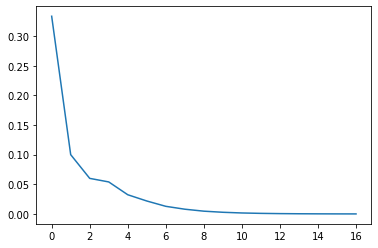

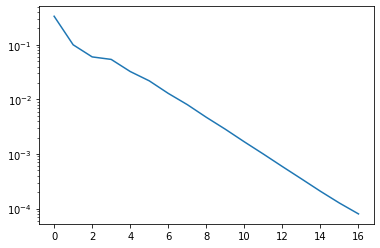

In [31]:
# %load solutions/RL1_exercice7.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


## <a id="optimality"></a>Optimality equation

Ok, so given a policy, we have a way (two actually) to compute its value function. Now we would like to find the optimal policy and we'd rather not enumerate all possible policies.

Let's introduce some notations and start with two trivial remarks. We write:
$$V^{\pi^*} = V^*, \quad Q^{\pi^*} = Q^*$$

Then we can note that:
1. $Q^*\left(s,a\right) = r\left(s,a\right) + \gamma \sum\limits_{s'\in S}p\left(s'|s,a\right) V^*\left(s'\right)$
2. If $\pi^*$ is an optimal policy, then $V^*\left(s\right) = Q^*\left(s,\pi^*\left(s\right)\right)$

From the first remark, we note that the maximum expected return one can get from a trajectory initiated in $s$ starts with the action $a$ that maximizes $Q^*(s,a)$. So:
<div class="alert alert-success"><b>Optimal greedy policy</b><br>
Any policy $\pi$ defined by $\pi(s) \in \arg\max\limits_{a\in A} Q^*(s,a)$ is an optimal policy.
</div>

Consequently, finding $\pi^*$ is equivalent to finding $Q^*$.

Here comes the key theorem of this class:
<div class="alert alert-success"><b>Bellman optimality equation</b><br>
The optimal value function obeys:
$$V^*(s) = \max\limits_{a\in A} \left\{ r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a) V^*(s') \right\}=(T^* V^*) (s)$$
or in terms of $Q$-functions:
$$Q^*(s,a) = r(s,a) + \gamma \sum\limits_{s'\in S}p(s'|s,a) \max\limits_{a'\in A} Q^*(s',a')=(T^* Q^*) (s,a)$$
</div>

Why does that unfold intuitively from the previous remarks? Simply because of the Dynamic Programming principle: any subpath of an optimal path is itself optimal. That might still sound obscure. So let's say that if you start a trajectory in $s$ and if you know you will get the maximum value from any state $s'$ you reach, then the maximum value you can get from $s$ is precisely $\max\limits_{a\in A} \left\{ r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a) V^*(s') \right\}$. The actual proof is quite trickier but the key ideas are here.<br>
<br>
As for the policy evaluation operator $T^\pi$, we define the **Bellman optimality operator** $T^*$ as above.<br>
<br>
<div class="alert alert-success"><b>Properties of $T^*$</b><br>
<ol>
<li> $T^*$ is non-linear.<br>
<li> With $\gamma<1$, $T^*$ is a $\| \cdot \|_\infty$-contraction mapping over the $\mathcal{F}(S,\mathbb{R})$ (resp. $\mathcal{F}(S\times A,\mathbb{R})$) Banach space.<br>
$\Rightarrow$ With $\gamma<1$, $V^*$ (resp. $Q^*$) is the unique solution to the fixed point equation:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$V=T^* V$ (resp. $Q=T^* Q$).
</ol>
</div>

<div class="alert alert-warning"><b>Exercice</b><br>
Use the property above to compute $V^*$. To do this, you'll need to remember that since $T^*$ is a contraction mapping, the sequence $V_{n+1}=T^* V_n$ converges to $T^*$'s fixed point (which happens to be $V^*$ according to the property). Again, $\gamma = 0.9$.
</div>

In [35]:
# %load solutions/RL1_exercice8.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


## <a id="summary"></a>Summary

Let's wrap this whole section up. Our goal was to formally define the search for the best strategy for our game of FrozenLake and the medical prescription problem. This has led us to formalizing the general **discrete-time stochastic optimal control problem**:
- Environment (discrete time, non-deterministic, non-linear, Markov) $\leftrightarrow$ MDP.
- Behaviour $\leftrightarrow$ control policy $\pi : s\mapsto a$.
- Policy evaluation criterion $\leftrightarrow$ $\gamma$-discounted criterion.
- Goal $\leftrightarrow$ Maximize value function $V^\pi(s)$, $Q^\pi(s,a)$.
- Evaluation eq. $\leftrightarrow$ $V^\pi = T^\pi V^\pi$, $Q^\pi = T^\pi Q^\pi$, linear equation, contraction mapping.
- Bellman optimality eq. $\leftrightarrow$ $V^* = T^* V^*$, $Q^* = T^* Q^*$, non-linear equation, contraction mapping.

# <a id="before"></a>Before you leave

## <a id="limits"></a>Limitations

What if the system is an MDP but its state is not fully observable?  
$\rightarrow$ This is the (exciting) field of Partially Observable MDPs. Our key result of having a Markovian optimal policy does not hold anymore. There are ways to still obtain optimal policies (but it is often very computationaly costly) or approximate them with Markovian policies.

What happens if there are multiple actions taken at the same time by different agents?  
$\rightarrow$ This falls into the category of multi-player stochastic games. Such games can be adversarial, cooperative, or a mix of the two. Of course they can also have partial observability.

What if the transition model is not Markovian?  
$\rightarrow$ Beware, here be dragons! All the beautiful framework above crumbles down if its hypothesis are violated. So great care should be taken when choosing the state variables for a given problem. In a sense, an MDP is a discrete time version of a first-order differential equation. Writing a system as $\dot{X} = f(X,U, noise)$ as is common in Control Theory is a good practice to ensure the Markov property.

## <a id="misconception"></a>Common misconception

You will often see the following type of drawing, along with the sentence like "RL is concerned with the problem on an agent performing actions to control an environment". 

<img src="img/misconception.png" style="height: 300px;"></img>

Although this sentence is not false *per se*, it conveys an important misconception that may be grounded in too simple anthropomorphic analogies. One often talks about the *state of the agent* or the *state of the environment*. The distinction here is confusing at best: there is no separation between agent and environment. A better vocabulary is to talk about a *system to control*, that is described through its observed *state*. This system is controlled by the application of actions issued from a *policy* or *control law*. The process of *learning* this policy is what RL is concerned with.

Although less shiny, the drawing below may be less misleading.

<img src="img/dynamic.png" style="height: 300px;"></img>